In [1]:
# Model name as saved to gcs (it can be found in the model_name config key in wandb)
# wandb run: stoic-gorge-48
MODEL_NAME = "20220528-212725_03_tacotron_8khz_overfit__TacotronTTS"
LOCAL_MODEL_DIR = 'copied_models'

In [2]:
# Access project root dir
import git
import os
root_dir = git.Repo('.', search_parent_directories=True).working_tree_dir

os.chdir(root_dir) # Ugly way to get access to imports but this way is also easier for ginconfig

In [3]:
%load_ext autoreload
%autoreload 2


from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython
import tensorflow as tf
import subprocess

import prepare_data
import training
import cloud_training
import utils
import models
import gin

gin.parse_config_file('config/cloud_gpu.gin')
gin.parse_config_file('config/experiments/03_tacotron_8khz_overfit.gin')
gin.enter_interactive_mode()

fft_length = gin.query_parameter('%fft_length')
frame_length = gin.query_parameter('%frame_length')
frame_step = gin.query_parameter('%frame_step')
sample_rate = gin.query_parameter('%sample_rate')

gsutil = os.path.dirname(gin.query_parameter('gcloud.gcloud_path')) + '/gsutil'
gcs_model_path = gin.query_parameter('gcloud_remote_training.gcs_model_path')

2022-05-29 13:43:31.018317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-29 13:43:31.018472: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [4]:
train_dataset, _ = prepare_data.datasets(target_sample_rate=sample_rate, keep_audio=True, keep_raw_spectrogram=True, keep_transcription=True)

batch = list(train_dataset.take(1))[0]
spectrogram, mel_spec, enc_transcription, audio, raw_spectrogram, transcription = (col[0].numpy() for col in batch)

2022-05-29 13:43:49.676358: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


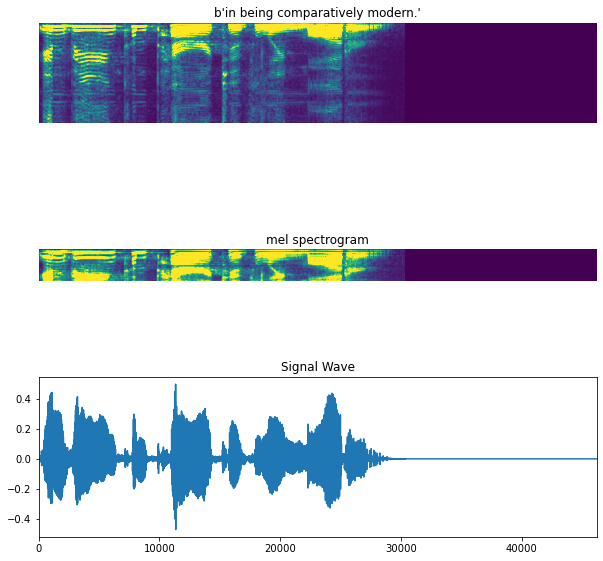

In [5]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 1, 1)
ax.imshow(np.transpose(spectrogram), vmax=1)
ax.set_title(transcription)
ax.axis("off")

ax = plt.subplot(3, 1, 2)
ax.imshow(np.transpose(mel_spec), vmax=1)
ax.set_title('mel spectrogram')
ax.axis("off")

ax = plt.subplot(3, 1, 3)
plt.plot(np.transpose(audio))
ax.set_title("Signal Wave")
ax.set_xlim(0, len(audio))
    
IPython.display.display(IPython.display.Audio(np.transpose(audio), rate=sample_rate))
plt.show()


In [6]:
# Download model and load it
cmd = [gsutil, '-m', 'cp', '-r', gcs_model_path + MODEL_NAME + '*', LOCAL_MODEL_DIR]
res = subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [19]:
tts = models.TacotronTTS()
tts.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME + '/final')

# model after first epoch
tts_0 = models.TacotronTTS()
tts_0.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME + '/epoch_0')

In [86]:
GEN_FRAMES = 600

def summarize_mel_stats(mel_spec, new_mel_spec):
    ref_spec = mel_spec[:GEN_FRAMES,:].flatten()
    pred_spec = new_mel_spec[0].numpy().flatten()
    print(f'L1 {np.abs(pred_spec - ref_spec).mean()}')
    return pd.DataFrame({
        'mel_spec': mel_spec[:GEN_FRAMES,:].flatten(),
        'predicted_mel_spec': new_mel_spec[0].numpy().flatten()
    }).describe()

def mel_spec_viz(mel_spec, extra_title=''):
    ax = plt.subplot(2, 1, 1)
    ax.imshow(np.transpose(new_mel_spec[0]), vmax=1)
    ax.set_title('predicted mel spectrogram' + extra_title)
    ax.axis("off")

    ax = plt.subplot(2, 1, 2)
    ax.imshow(np.transpose(new_mel_spec[0]))
    ax.set_title('predicted mel spectrogram normalized' + extra_title)
    ax.axis("off")
    plt.show()
    
def encoder_viz(tts, input):
    encoded, _ = tts.tacotron_encoder(input)
    embed = tts.tacotron_encoder.embeddings(input)
    pre_net = tts.tacotron_encoder.pre_net(embed)

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(encoded[0]))
    ax.set_title('encoded transcription')
    ax.axis("off")
    plt.show()
    
    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(embed[0]))
    ax.set_title('embedded transcription')
    ax.axis("off")
    plt.show()
    
    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(pre_net[0]))
    ax.set_title('pre_net transcription')
    ax.axis("off")

    plt.show()
    
def encoder_viz(tts, input):
    encoded, _ = tts.tacotron_encoder(input)
    mask = input == tf.constant(-1, dtype=tf.int64)
    embed = tts.tacotron_encoder.embeddings(input)
    pre_net = tts.tacotron_encoder.pre_net(embed)
    conv_bank = tts.tacotron_encoder.cbhg.conv_bank(pre_net)
    pooling = tts.tacotron_encoder.cbhg.pooling(conv_bank)
    conv_proj1 = tts.tacotron_encoder.cbhg.conv_proj1(pooling)
    conv_proj2 = tts.tacotron_encoder.cbhg.conv_proj2(conv_proj1)
    pre_rnn = pre_net + conv_proj2
    rnn = tts.tacotron_encoder.cbhg.rnn_encoder(pre_rnn, mask=mask)
    proj = tts.tacotron_encoder.cbhg.proj(rnn)

    plt.figure(figsize=(14, 8))
    
    data_sets = [
        encoded, embed, pre_net, conv_bank, pooling,
        conv_proj1, conv_proj2, pre_rnn, rnn, proj
    ]
    captions = [
        'encoded', 'embedded', 'pre_net', 'conv_bank', 'pooling',
        'conv_proj1', 'conv_proj2', 'pre_rnn', 'rnn', 'proj'
    ]
    
    for ix, (caption, data) in enumerate(zip(captions, data_sets)):
        ax = plt.subplot(1, len(data_sets), ix+1)
        ax.imshow(np.transpose(data[0]))
        ax.set_title(caption)
        ax.axis("off")
        
    plt.show()

In [32]:
# Generate mel_specs

input = tf.expand_dims(enc_transcription[enc_transcription!=-1], 0)
new_mel_spec = tts.decode(input, GEN_FRAMES)
new_mel_spec_0 = tts_0.decode(input, GEN_FRAMES)

In [22]:
summarize_mel_stats(mel_spec, new_mel_spec)

L1 0.5165034532546997


,mel_spec,predicted_mel_spec
count,24000.000000,24000.000000
mean,0.516777,0.000323
std,0.527056,0.001927
min,0.000000,-0.004528
25%,0.098989,-0.000129
50%,0.375960,0.000030
75%,0.765602,0.000266
max,3.915968,0.023897


In [23]:
summarize_mel_stats(mel_spec, new_mel_spec_0)

L1 0.5153535604476929


,mel_spec,predicted_mel_spec
count,24000.000000,24000.000000
mean,0.516777,0.002512
std,0.527056,0.001591
min,0.000000,-0.000353
25%,0.098989,0.001279
50%,0.375960,0.002499
75%,0.765602,0.003351
max,3.915968,0.007595


Not looking good, last model having higher loss

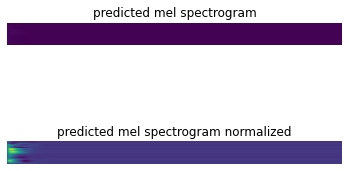

In [24]:
mel_spec_viz(new_mel_spec)

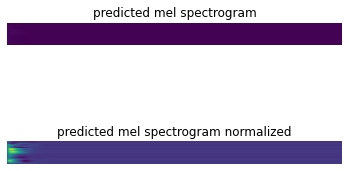

In [25]:
mel_spec_viz(new_mel_spec_0)

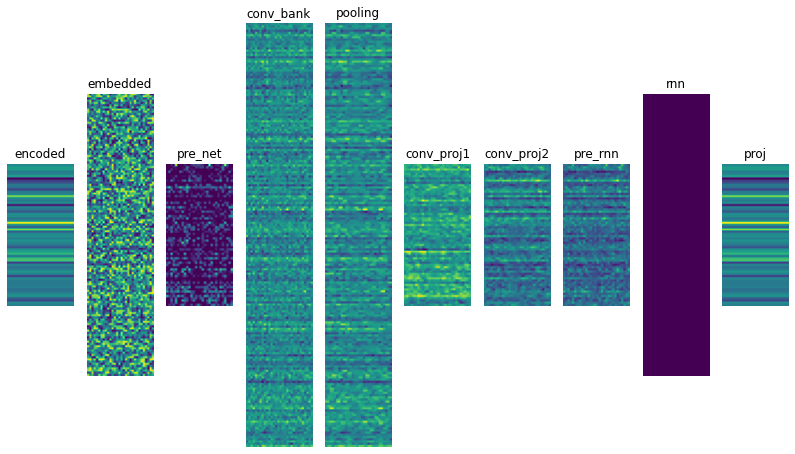

In [87]:
encoder_viz(tts, input)

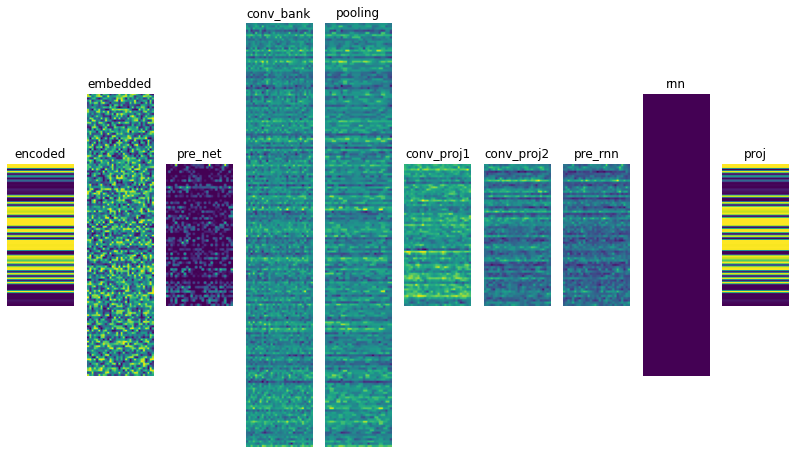

In [88]:
encoder_viz(tts_0, input)

Apparently masking is complete broken 😅. (A dumb condition in the encoder that is also reproduced in the visualization code).